# ARIMA Model

We experimented with using a third model, following our experiments with Random Forest and Negative Binomial Regression.

AutoRegressive Moving Average (ARIMA) model means:

- AutoRegressive (AR): This captures the relationship between an observation and a number of lagged observations. It's the component that allows the model to learn from past values.
- Integrated (I): This involves differencing the time series data to make it stationary. A stationary time series has properties like mean and variance that do not change over time, which is a common assumption in many time series models.
- Moving Average (MA): This component models the relationship between an observation and a residual error from a moving average model applied to lagged observations. It helps to smooth out noise in the data.

In this notebook, we split the DataFrames between the two cities, and attempt to predict future cases of Dengue Fever, only from the `week_start_date` feature.

# Import Modules

In [19]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
plt.style.use("dark_background")
from warnings import filterwarnings
filterwarnings('ignore')

# Load Data

In [20]:
# Load the data
train_features = pd.read_csv('../data/dengue_features_train.csv')
train_labels = pd.read_csv('../data/dengue_labels_train.csv')

# Transform Data

In [21]:
# Convert 'week_start_date' to datetime
train_features['week_start_date'] = pd.to_datetime(train_features['week_start_date'])

# Merge features and labels on the city, year, and weekofyear columns
train_data = train_features.merge(train_labels, on=['city', 'year', 'weekofyear'])

# Split the data by city
sj_data = train_data[train_data['city'] == 'sj']
iq_data = train_data[train_data['city'] == 'iq']

# Preprocess Data and Fit Model

In [22]:
# Function to preprocess and fit ARIMA model for a given city's data
def preprocess_and_fit_arima(city_data):
    # Set 'week_start_date' as the index
    city_data.set_index('week_start_date', inplace=True)

    # Forward-fill missing values
    city_data.ffill(inplace=True)

    # Ensure the index is sorted in increasing order
    if not city_data.index.is_monotonic_increasing:
        city_data.sort_index(inplace=True)

    # Define and fit the ARIMA model on the data
    arima_model = ARIMA(city_data['total_cases'], order=(1,1,1))
    model_fit = arima_model.fit()

    return model_fit

# Fit ARIMA models for each city
sj_model_fit = preprocess_and_fit_arima(sj_data)
iq_model_fit = preprocess_and_fit_arima(iq_data)


# Forecast and Plot Predictions

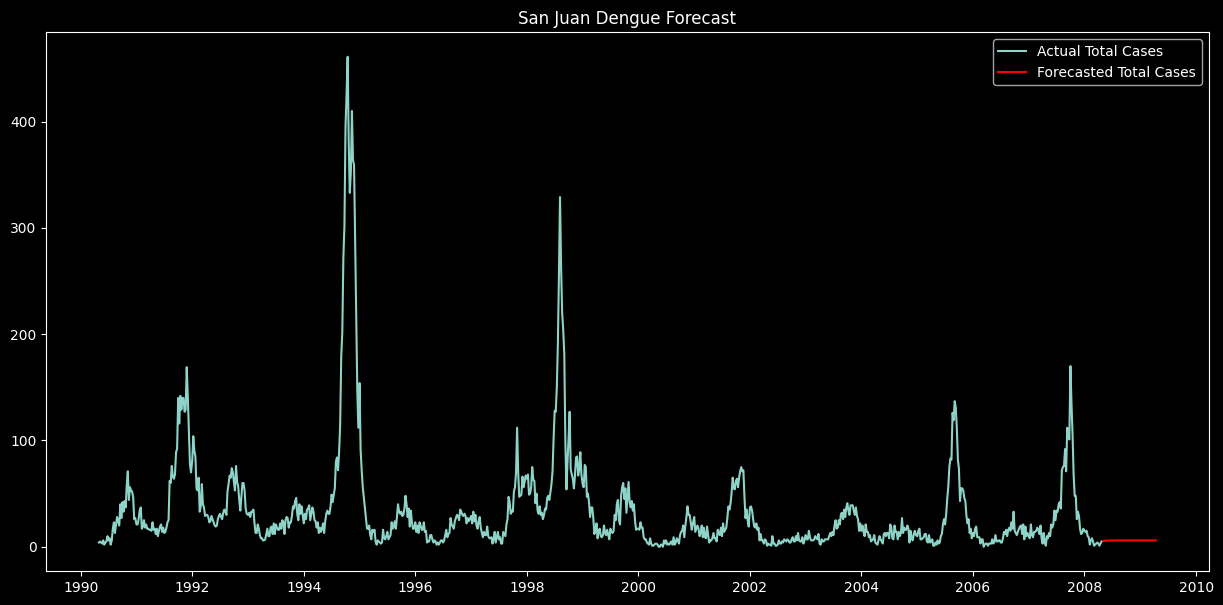

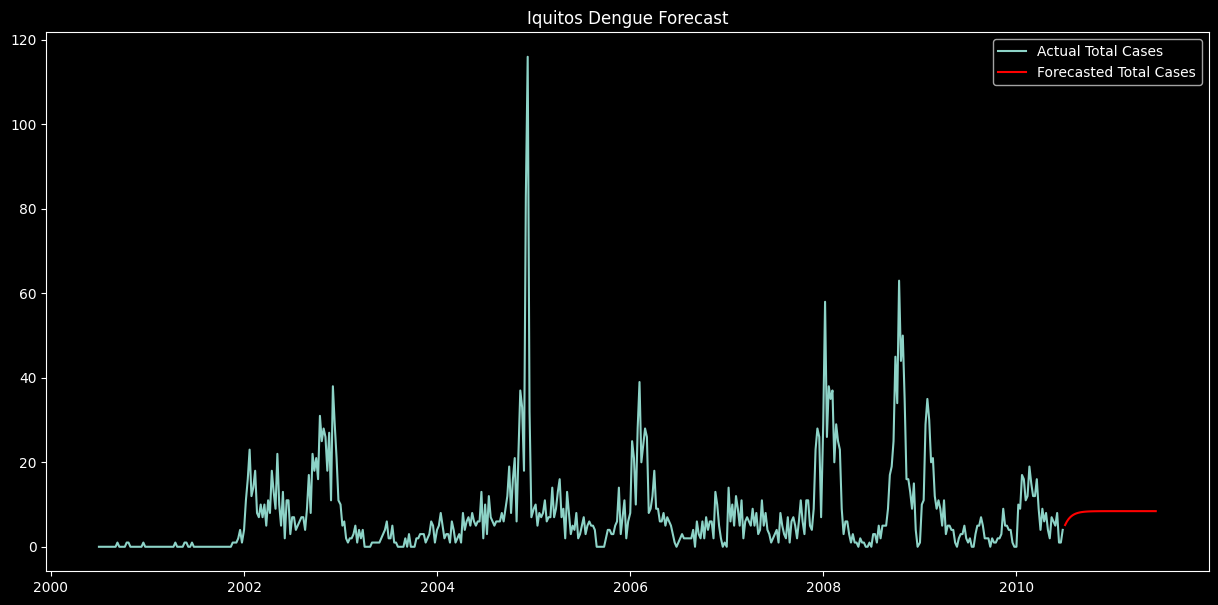

In [23]:
# Forecasting function for a given city's data and model
def forecast_and_plot(city_data, city_name, model_fit):
    # Forecast future values
    n_forecast = 50  # Number of periods to forecast into the future
    forecast_index = pd.date_range(start=city_data.index.max(), periods=n_forecast + 1, freq='W-SUN')[1:]
    forecast = model_fit.get_forecast(steps=n_forecast).predicted_mean

    # Create a DataFrame for the forecast data
    forecast_table = forecast.to_frame(name='Forecasted Total Cases')
    forecast_table.index = forecast_index  # Set the forecast index with the appropriate dates

    # Plot the data
    plt.figure(figsize=(15,7))
    plt.plot(city_data.index, city_data['total_cases'], label='Actual Total Cases')
    plt.plot(forecast_table.index, forecast_table['Forecasted Total Cases'], label='Forecasted Total Cases', color='red')
    plt.title(f'{city_name} Dengue Forecast')
    plt.legend()
    plt.show()

# Forecast and plot for each city
forecast_and_plot(sj_data, 'San Juan', sj_model_fit)
forecast_and_plot(iq_data, 'Iquitos', iq_model_fit)




# Reflections

This was an interesting exercise in applying an ARIMA model!

The model successfully makes future predictions.

But these predictions are not so impressive; they level off after around one year.

So, there's a lot of future work that could be done to improve the model. We could try:

- **SARIMA (Seasonal ARIMA)**: This model extends ARIMA by adding support for seasonality. SARIMA models are effective when the data exhibits clear seasonal patterns. The seasonal components in SARIMA allow the model to fit and forecast based on seasonal trends.

- **Vector Autoregression (VAR)**: Our dataset contains multiple time series that influence each other (e.g., temperature and humidity affecting dengue cases), and VAR models can capture the interdependencies between multiple variables.

- **Machine Learning Models**: Techniques such as Random Forests (used in our revised pipeline), Gradient Boosting Machines (e.g., XGBoost, LightGBM), and Support Vector Machines can be used for time series forecasting. These models can capture complex nonlinear relationships in the data. Feature engineering (e.g., lagged variables, rolling statistics) is crucial when using these models for time series forecasting.

- **Deep Learning Models**: Deep learning models like Long Short-Term Memory (LSTM) networks, Gated Recurrent Units (GRUs), and Temporal Convolutional Networks (TCNs) are well-suited for capturing long-term dependencies and complex patterns in time series data.

A key insight from this final exploration is that we cannot predict cases of Dengue Fever using one time series - `week_start_date` - alone. Instead, we would need to build a model that combines insights from both temporal `datetime` variables, along with temperature and humidity variables found to moderately correlate with total number of Dengue cases.